In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from tabpfn import TabPFNClassifier
from sklearn.metrics import accuracy_score, classification_report
import torch

In [3]:
df = pd.read_csv('processed-data.csv')

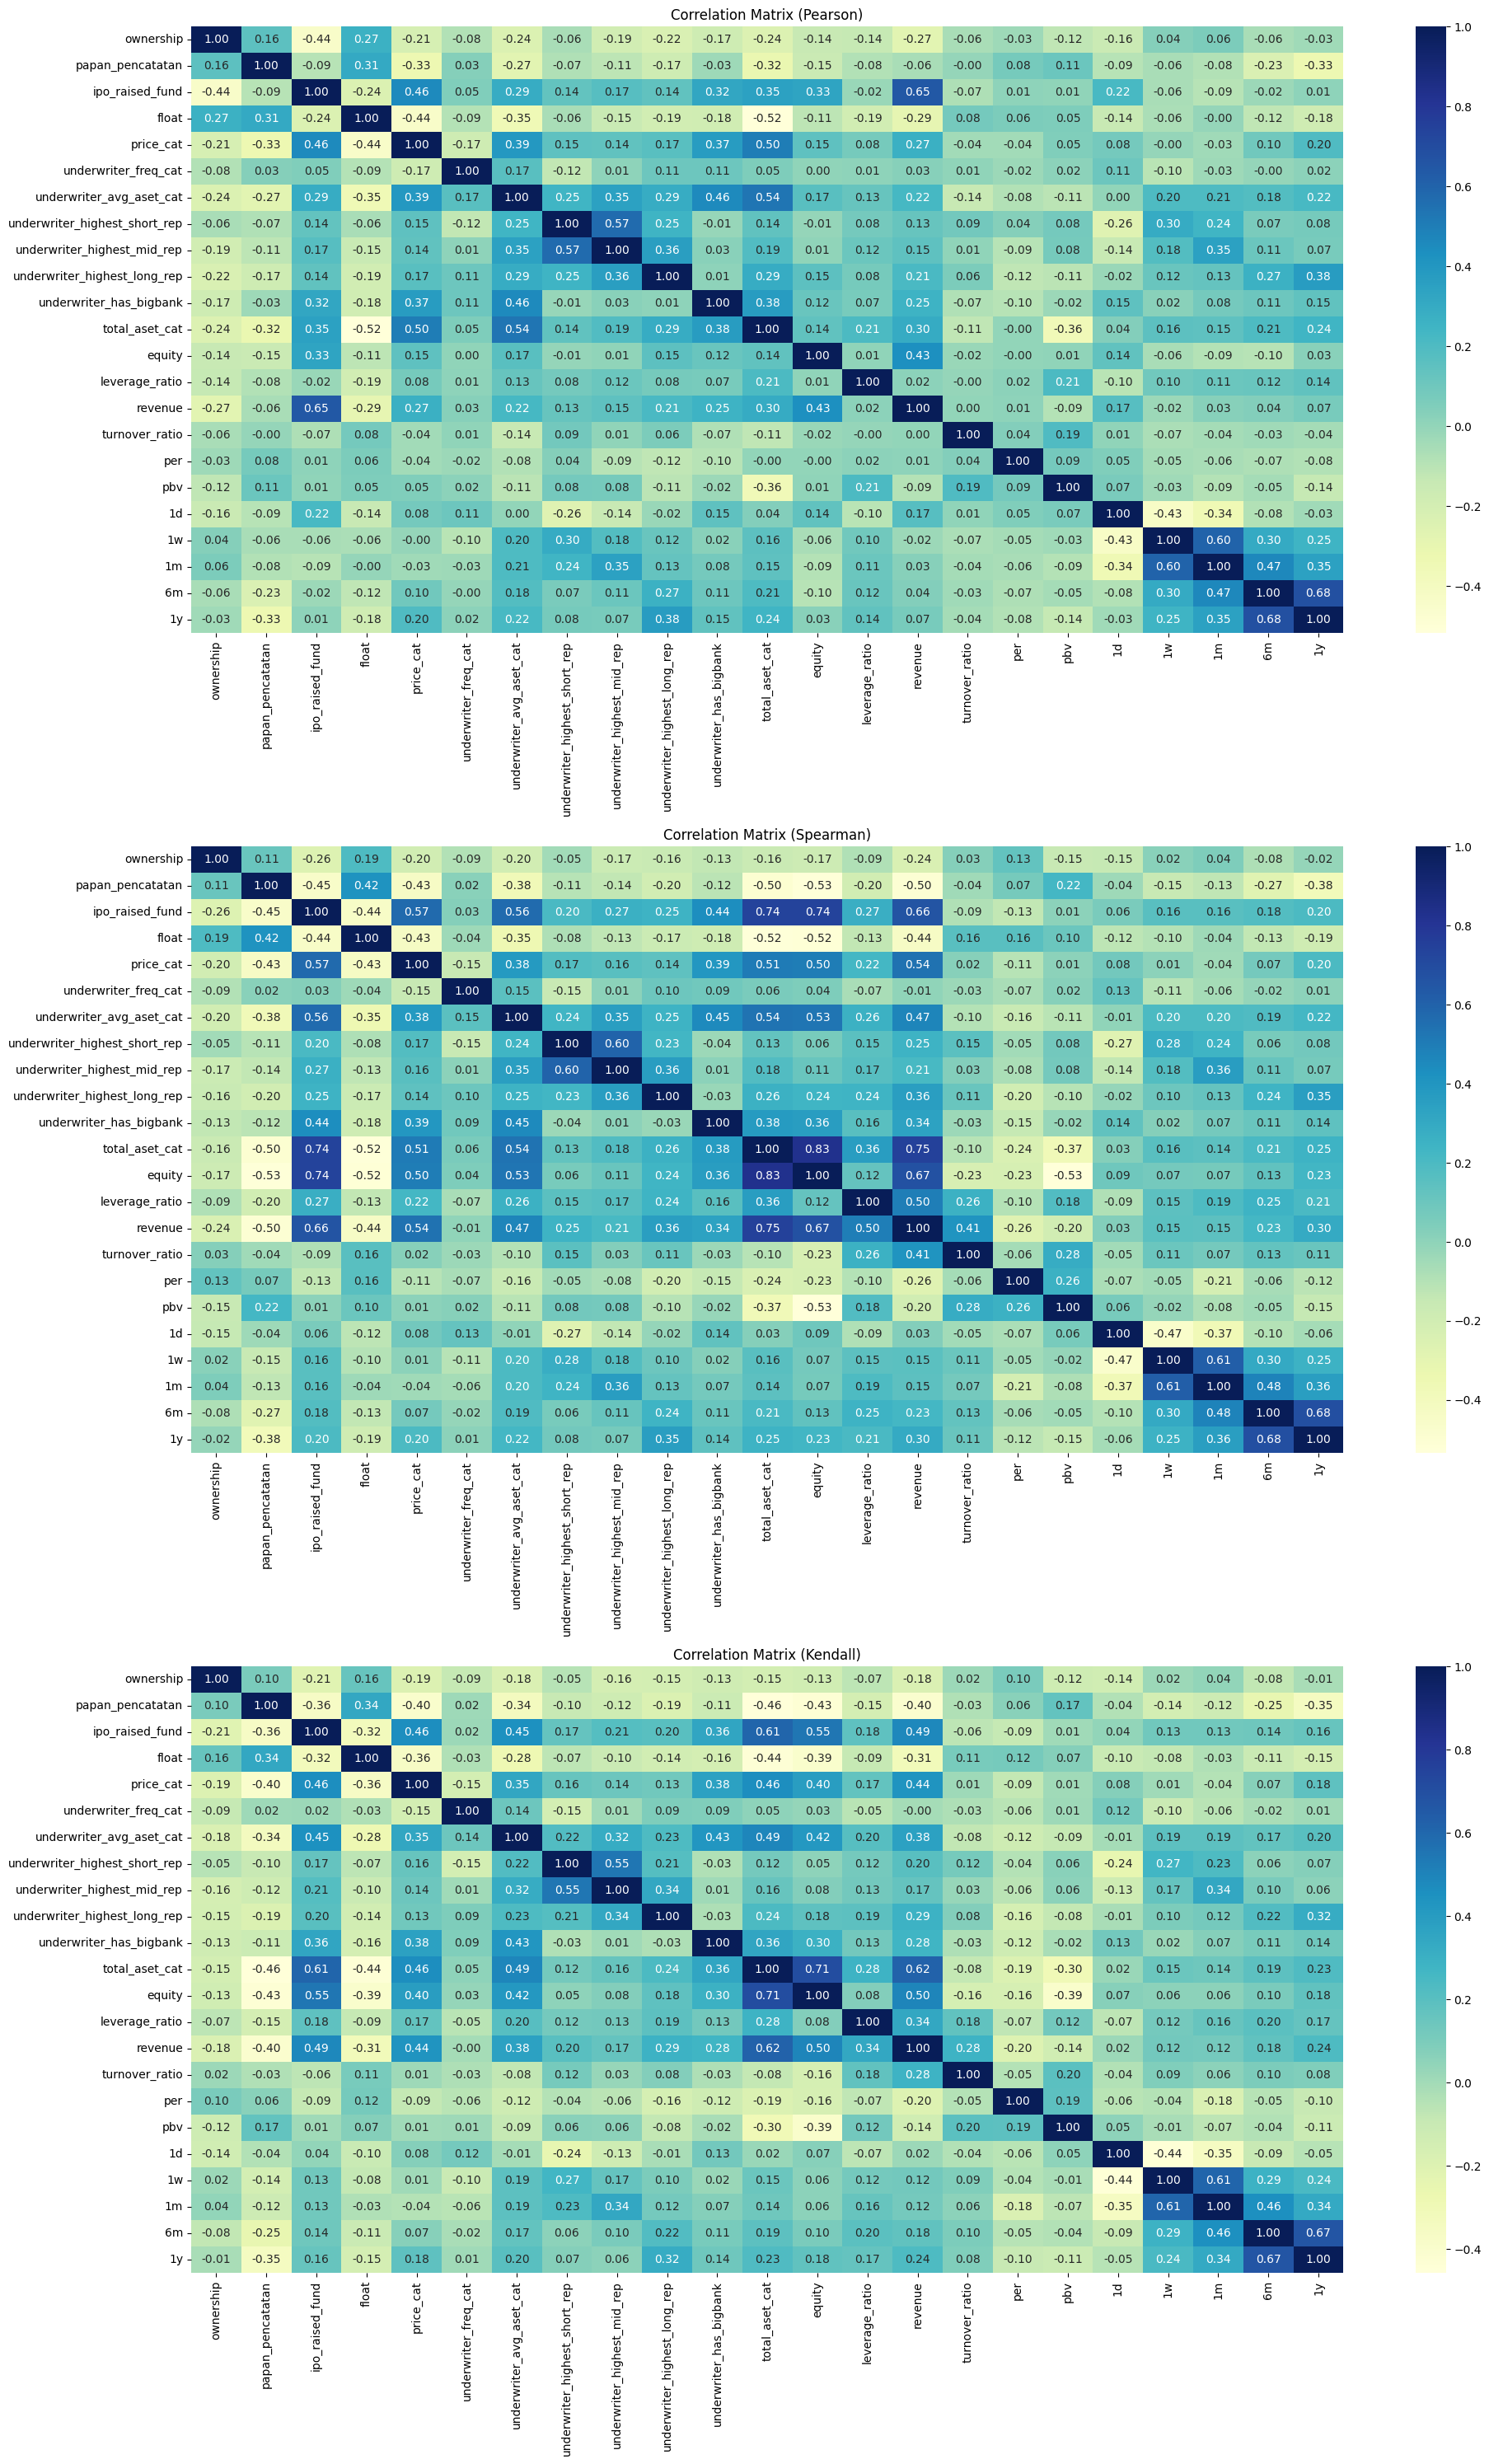

In [4]:
corr_methods = ['pearson', 'spearman', 'kendall']
plt.figure(figsize=(20, 10 * len(corr_methods)))

for i, method in enumerate(corr_methods, 1):
    plt.subplot(len(corr_methods), 1, i)
    corr = df.iloc[:].corr(method=method)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='YlGnBu', cbar=True)
    plt.title(f'Correlation Matrix ({method.title()})')

plt.tight_layout()
plt.show()

In [19]:
feature_cols = [
    'papan_pencatatan', 'ipo_raised_fund', 'float', 'price_cat',
    'underwriter_avg_aset_cat', 'underwriter_highest_long_rep', 'underwriter_has_bigbank',
    'total_aset_cat', 'equity', 'leverage_ratio', 'revenue', 'pbv'
]

X = df[feature_cols]
y = df['1y']

mask = y != 1
X = X[mask]
y = y[mask]

y = y.replace({2: 1})

X_train = X.iloc[:170]
X_test = X.iloc[170:]
y_train = y.iloc[:170]
y_test = y.iloc[170:]


Accuracy: 0.6956521739130435
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.67      0.25      0.36         8

    accuracy                           0.70        23
   macro avg       0.68      0.59      0.58        23
weighted avg       0.69      0.70      0.65        23



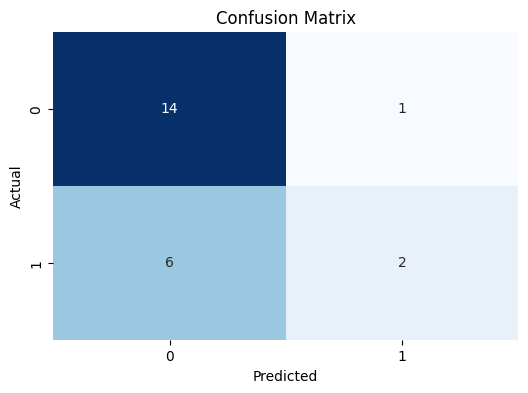

In [20]:
# classifier
clf = TabPFNClassifier(device='cuda' if torch.cuda.is_available() else 'cpu')

# fit n predict
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# eval
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
from lime.lime_tabular import LimeTabularExplainer

def explain_with_lime(model, X_train, X_test, feature_names, class_names):
    explainer = LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        discretize_continuous=True
    )

    sample = X_test.iloc[0].values
    explanation = explainer.explain_instance(sample, model.predict_proba, num_features=len(feature_names))

    explanation.show_in_notebook(show_table=True)
    explanation.as_pyplot_figure()
    plt.tight_layout()
    plt.show()

In [ ]:
explain_with_lime(
    model=clf,
    X_train=X_train,
    X_test=X_test,
    feature_names=X_train.columns.tolist(),
    class_names=['minus', 'plus']
)
